# Mimic of the DES night summary, but for Rubin Observatory

In [5]:
# This cell is only for setting parameter defaults
day_obs = "2027-11-10"
visit_db_fname = None

In [6]:
import datetime
import sys
from IPython.display import display, HTML
import pandas as pd
import bokeh
import bokeh.io
import bokeh.plotting
import bokeh.models
import bokeh.transform
import bokeh.layouts
import sqlite3
import numpy as np
import healpy
import astropy
import colorcet
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import healpy as hp
import astropy.units as u
from astropy.visualization import ZScaleInterval
from astropy.time import Time
from astropy.coordinates import SkyCoord, get_body
from lsst.resources import ResourcePath

In [7]:
sys.path.insert(0, '/sdf/data/rubin/user/neilsen/devel/uranography')
sys.path.insert(0, '/sdf/data/rubin/user/neilsen/devel/rubin_scheduler')
sys.path.insert(0, '/sdf/data/rubin/user/neilsen/devel/rubin_sim')
sys.path.insert(0, '/sdf/data/rubin/user/neilsen/devel/schedview')

In [8]:
import rubin_scheduler
import rubin_scheduler.utils
import rubin_scheduler.site_models
import schedview.compute.astro
import schedview.compute.visits
import uranography
import schedview.plot.visitmap

from rubin_sim import maf
from rubin_sim.data import get_baseline
from schedview.compute.camera import LsstCameraFootprintPerimeter
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from uranography.api import Planisphere, make_zscale_linear_cmap

In [9]:
%load_ext autoreload
%autoreload 1

In [10]:
%aimport schedview.plot.survey_skyproj

In [11]:
print("Here!")

Here!


In [12]:
bokeh.io.output_notebook()

Loading BokehJS ...

In [13]:
%matplotlib inline

In [14]:
astropy.utils.iers.conf.iers_degraded_accuracy = 'ignore'

In [15]:
if visit_db_fname is None:
    visit_db_fname = get_baseline()

In [16]:
baseline_opsim_rp = ResourcePath(visit_db_fname)
day_obs_mjd = int(Time(day_obs).mjd)
observatory = ModelObservatory(init_load_length=1)
timezone = "Chile/Continental"
use_matplotlib = True

In [17]:
visits = schedview.collect.read_opsim(baseline_opsim_rp, constraint=f"FLOOR(observationStartMJD-0.5)={day_obs_mjd}")
visits = schedview.compute.visits.add_day_obs(visits)
visits = schedview.compute.visits.add_maf_metric(visits, maf.TeffMetric(), 'teff')
visits = schedview.compute.visits.add_coords_tuple(visits)
visits = schedview.compute.visits.add_overhead(visits)

Using fiducial depths for t_eff calculation from https://github.com/lsst-sims/smtn-002/blob/main/notebooks/teff_fiducial.ipynb commit e367d65.
These probably should be updated.

### Sun and Moon

In [18]:
day_obs_datetime = Time(day_obs_mjd, format='mjd').datetime
day_obs_date = datetime.date(day_obs_datetime.year, day_obs_datetime.month, day_obs_datetime.day)
night_events = schedview.compute.astro.night_events(day_obs_date)
night_events

MJD         LST                              UTC  \
event                                                                        
sunset           61719.964397  326.317054 2027-11-10 23:08:43.921000+00:00   
sun_n12_setting  61720.006751  341.606016 2027-11-11 00:09:43.253000+00:00   
sun_n18_setting  61720.029259  349.731393 2027-11-11 00:42:08.019000+00:00   
sun_n18_rising   61720.341286  102.368629 2027-11-11 08:11:27.145000+00:00   
sun_n12_rising   61720.363801  110.495932 2027-11-11 08:43:52.372000+00:00   
sunrise          61720.406151  125.783733 2027-11-11 09:44:51.427000+00:00   
moonrise         61720.879471  296.645446 2027-11-11 21:06:26.274000+00:00   
moonset          61720.318827   94.261095 2027-11-11 07:39:06.650000+00:00   
night_middle     61720.185274   46.050393 2027-11-11 04:26:47.674000+00:00   

                               Chile/Continental  
event                                             
sunset          2027-11-10 20:08:43.921000-03:00  
sun_n12_setting 2027-11-10 21:09:43.253000-03:00  
sun_n18_setting 2027-11-10 21:42:08.019000-03:00  
sun_n18_rising  2027-11-11 05:11:27.145000-03:00  
sun_n12_rising  2027-11-11 05:43:52.372000-03:00  
sunrise         2027-11-11 06:44:51.427000-03:00  
moonrise        2027-11-11 18:06:26.274000-03:00  
moonset         2027-11-11 04:39:06.650000-03:00  
night_middle    2027-11-11 01:26:47.674000-03:00

In [19]:
print(f"Moon phase: {visits['moonPhase'].median()}")

Moon phase: 79.63021777734996


In [20]:
model_observatory = ModelObservatory(init_load_length=1)
model_observatory.mjd = night_events.loc['night_middle', 'MJD']

## Conditions and statistics

### Numbers of exposures, and gaps between them

In [21]:
overhead_summary = schedview.compute.visits.compute_overhead_summary(visits, night_events.loc['sun_n12_setting','MJD'], night_events.loc['sun_n12_rising','MJD'])
summary_table = schedview.plot.create_overhead_summary_table(overhead_summary)
display(HTML(summary_table))

## Histogram of gaps between exposures

In [22]:
p1 = schedview.plot.create_overhead_histogram(visits)
p2 = schedview.plot.plot_overhead_vs_slew_distance(visits)
overhead_plots = bokeh.layouts.row([p1, p2])
bokeh.io.show(overhead_plots)

## Long gaps between exposures

In [23]:
visits.head()

fieldRA  day_obs_mjd day_obs_date day_obs_iso8601  \
observationId                                                         
574815         273.872670        61719   2027-11-10      2027-11-10   
574816         270.391667        61719   2027-11-10      2027-11-10   
574817         268.038960        61719   2027-11-10      2027-11-10   
574818         264.623586        61719   2027-11-10      2027-11-10   
574819         265.785372        61719   2027-11-10      2027-11-10   

                fieldDec                                    coords  \
observationId                                                        
574815        -26.811630    (273.8726704470863, -26.8116301378763)   
574816        -27.213913  (270.39166680762236, -27.21391346970812)   
574817        -24.908881  (268.0389602290315, -24.908880893637512)   
574818        -25.149016    (264.623585662104, -25.14901606049597)   
574819        -22.539402  (265.78537200464865, -22.53940169452576)   

               observationStartMJD  flush_by_mjd  visitExposureTime filter  \
observationId                                                                
574815                61720.007980  61720.030973               15.0      i   
574816                61720.008220  61720.030973               15.0      i   
574817                61720.008461  61720.030973               15.0      i   
574818                61720.008702  61720.030973               15.0      i   
574819                61720.008937  61720.030973               15.0      i   

               ...    moonRA   moonDec  moonDistance  solarElong  moonPhase  \
observationId  ...                                                            
574815         ...  7.581837  8.625128     97.165109   45.585422  78.955355   
574816         ...  7.583519  8.626532    100.292213   42.508255  78.956333   
574817         ...  7.585203  8.627937    102.233614   40.266136  78.957312   
574818         ...  7.586883  8.629339    105.338848   37.191895  78.958290   
574819         ...  7.588527  8.630711    104.141007   38.137282  78.959245   

                cummTelAz  scripted_id        HA  \
observationId                                      
574815        -104.870678            0  4.544933   
574816        -106.588953            0  4.782785   
574817        -105.108034            0  4.945426   
574818        -106.707225            0  5.178903   
574819        -103.664804            0  5.107110   

                                       start_date      teff  
observationId                                                
574815        2027-11-11 00:11:29.469806848+00:00  1.146870  
574816        2027-11-11 00:11:50.241490688+00:00  0.869830  
574817        2027-11-11 00:12:11.040894976+00:00  0.571835  
574818        2027-11-11 00:12:31.809601536+00:00  0.509358  
574819        2027-11-11 00:12:52.128139520+00:00  0.497905  

[5 rows x 53 columns]

In [24]:
num_gaps = 10
long_gap_visits = visits.sort_values('overhead', ascending=False).query('overhead>30').loc[:, ['start_date', 'overhead', 'slewDistance', 'filter', 'previous_filter']].sort_values('observationId')
long_gap_visits

start_date    overhead  slewDistance  \
observationId                                                                 
574857        2027-11-11 00:26:49.789980928+00:00   65.350099     44.964873   
574858        2027-11-11 00:28:00.498307840+00:00   40.708357     25.259204   
574865        2027-11-11 00:33:19.203398912+00:00   31.224192     18.328972   
574878        2027-11-11 00:42:58.907033856+00:00   44.703145     30.882515   
574928        2027-11-11 01:17:13.089816576+00:00  124.000000      3.165368   
574972        2027-11-11 01:48:14.066727168+00:00  160.000000     62.797226   
575066        2027-11-11 02:51:43.925844992+00:00  160.000000     61.970347   
575110        2027-11-11 03:20:48.978620672+00:00   30.278727     19.682278   
575160        2027-11-11 03:55:35.750685696+00:00  124.000000      2.954887   
575203        2027-11-11 04:26:18.298325760+00:00  160.000000     59.987296   
575224        2027-11-11 04:40:56.239007488+00:00   30.123305     10.764552   
575253        2027-11-11 05:01:59.236823808+00:00  124.000000      2.817896   
575267        2027-11-11 05:12:17.430815488+00:00   49.237083      8.707792   
575328        2027-11-11 05:54:04.170105344+00:00   47.089287     11.492996   
575337        2027-11-11 06:02:11.521555712+00:00  124.000000      2.986112   
575378        2027-11-11 06:29:27.224291072+00:00   47.271224     11.492996   
575435        2027-11-11 07:09:04.405804544+00:00  124.000000      2.810372   
575451        2027-11-11 07:20:06.805913088+00:00   48.545302     10.197480   
575463        2027-11-11 07:28:54.572795136+00:00   31.872447      6.168249   
575475        2027-11-11 07:39:31.172238848+00:00  160.000000     47.041064   
575485        2027-11-11 07:47:29.172221184+00:00  124.000000      0.000000   
575505        2027-11-11 08:01:27.172222208+00:00  124.000000      0.000000   
575515        2027-11-11 08:08:17.048655104+00:00   55.876443     32.169632   
575516        2027-11-11 08:09:23.619486976+00:00   36.570803     28.831878   
575530        2027-11-11 08:21:37.224560384+00:00  157.000000     48.039946   

              filter previous_filter  
observationId                         
574857             i               i  
574858             i               i  
574865             i               i  
574878             i               i  
574928             z               i  
574972             y               z  
575066             z               y  
575110             z               z  
575160             y               z  
575203             r               y  
575224             r               r  
575253             i               r  
575267             i               i  
575328             i               i  
575337             z               i  
575378             z               z  
575435             y               z  
575451             y               y  
575463             y               y  
575475             g               y  
575485             i               g  
575505             r               i  
575515             r               r  
575516             r               r  
575530             z               r

## PSF Width

In [25]:
p = schedview.plot.plot_visit_param_vs_time(visits, 'seeingFwhmEff')
p.yaxis.axis_label = "Effective PSF FWHM (asec)"
bokeh.io.show(p)

## Instrumental seeing

In [26]:
visits = schedview.compute.visits.add_instrumental_fwhm(visits)
p = schedview.plot.plot_visit_param_vs_time(visits, 'inst_fwhm')
p.yaxis.axis_label = "Instrumental contribution to the FWHM (asec)"
bokeh.io.show(p)

This perplexes me; I expected the instrumental contribution in simulations to be constant.

## PSF ellipticity

No ellipticity is simulated by opsim.

## Effective exposure time

In [27]:
p = schedview.plot.plot_visit_param_vs_time(visits, 'teff')
p.yaxis.axis_label = 'Effecive exposure time (sec.)'
p.title = "Effective exposure time"
bokeh.io.show(p)

## Sky brightness

In [28]:
p = schedview.plot.plot_visit_param_vs_time(visits, 'skyBrightness')
p.yaxis.axis_label = 'Sky brightness (mag/asec^2'
p.title = "Sky brightness"
bokeh.io.show(p)

## Cloud cover

When run with current opsim simulations, all simulations are either completely spoiled (infinite extinction) or clear (no extinction), and what is recorded is a fraction of the sky covered by clouds.

So, where the DES nightsum plots the extinction, what is plotted here is the recorded fraction cloud cover.

In [29]:
p = schedview.plot.plot_visit_param_vs_time(visits, 'cloud')
p.yaxis.axis_label = 'Cloud cover'
p.title = "Cloud cover"
bokeh.io.show(p)

## Visit map

In [30]:
vmap, vmap_data = schedview.plot.visitmap.create_visit_skymaps(
    visits=visits,
    night_date=day_obs_date,
    timezone=timezone,
    observatory=observatory,
)

INFO:healpy:Sigma is 254.796540 arcmin (0.074117 rad) 
INFO:healpy:-> fwhm is 600.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
/sdf/data/rubin/user/neilsen/devel/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:277: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


In [31]:
bokeh.io.show(vmap)

## Survey Progress

### Map depth accumulated so far

In [32]:
observatory.mjd = night_events.loc['night_middle', 'MJD']
conditions = observatory.return_conditions()
previous_visits = schedview.collect.read_opsim(visit_db_fname, constraint=f"observationStartMjd < {night_events.loc['sunset', 'MJD']}")

In [33]:
metric = maf.TeffMetric()
teff_hpix = schedview.compute.maf.compute_hpix_metric_in_bands(previous_visits, metric, nside=32)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


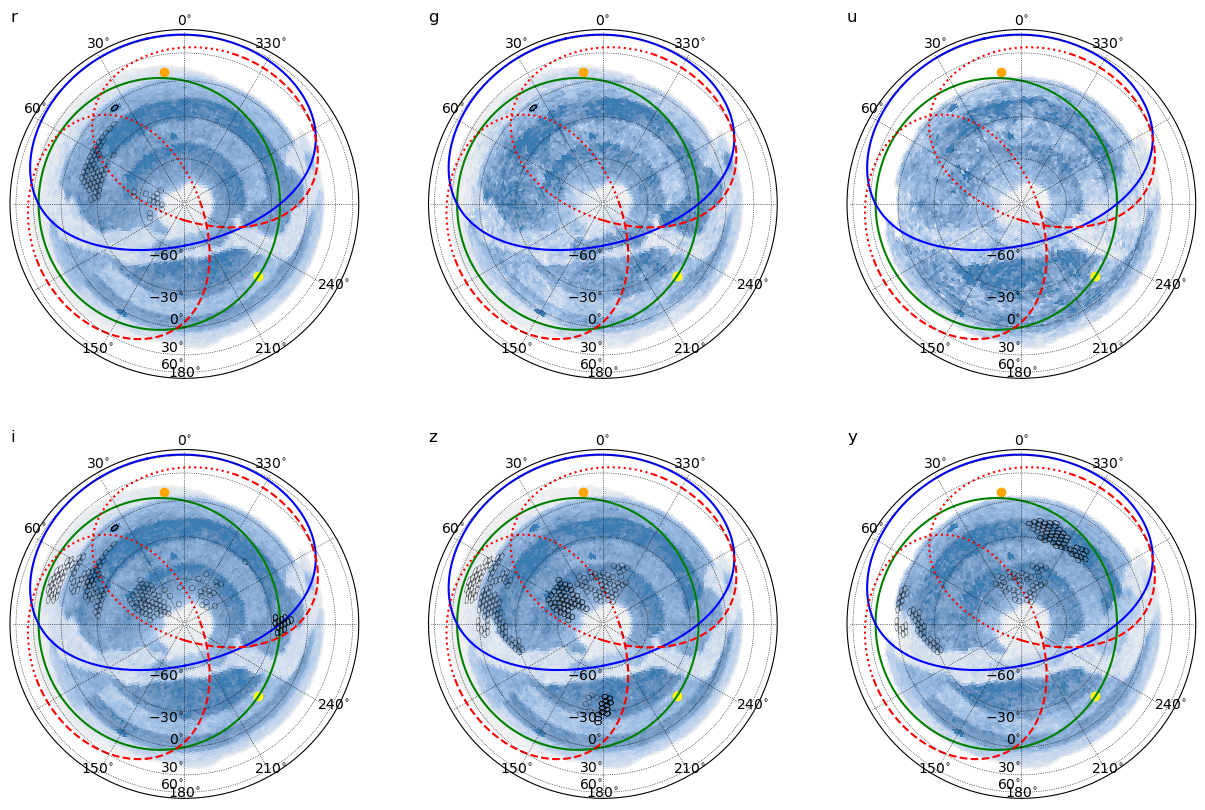

In [43]:
if use_matplotlib:
    fig = schedview.plot.survey_skyproj.create_hpix_visit_map_grid(visits, teff_hpix, model_observatory, night_events)
else:
    map_grid = schedview.plot.create_hpix_visit_map_grid(teff_hpix, visits, conditions)
    bokeh.io.show(map_grid)

### Map the most recent visit so far

In [35]:
metric = maf.MaxMetric('observationStartMJD')
latest_mjd_hpix = schedview.compute.maf.compute_hpix_metric_in_bands(previous_visits, metric, nside=32)
time_since_latest_hpix = {b: night_events.loc['sunset', 'MJD'] - latest_mjd_hpix[b].filled(np.nan) for b in latest_mjd_hpix}

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [36]:
long_limit = 30
for band in time_since_latest_hpix:
    long_hpix = time_since_latest_hpix[band] > long_limit
    time_since_latest_hpix[band][long_hpix] = np.nan

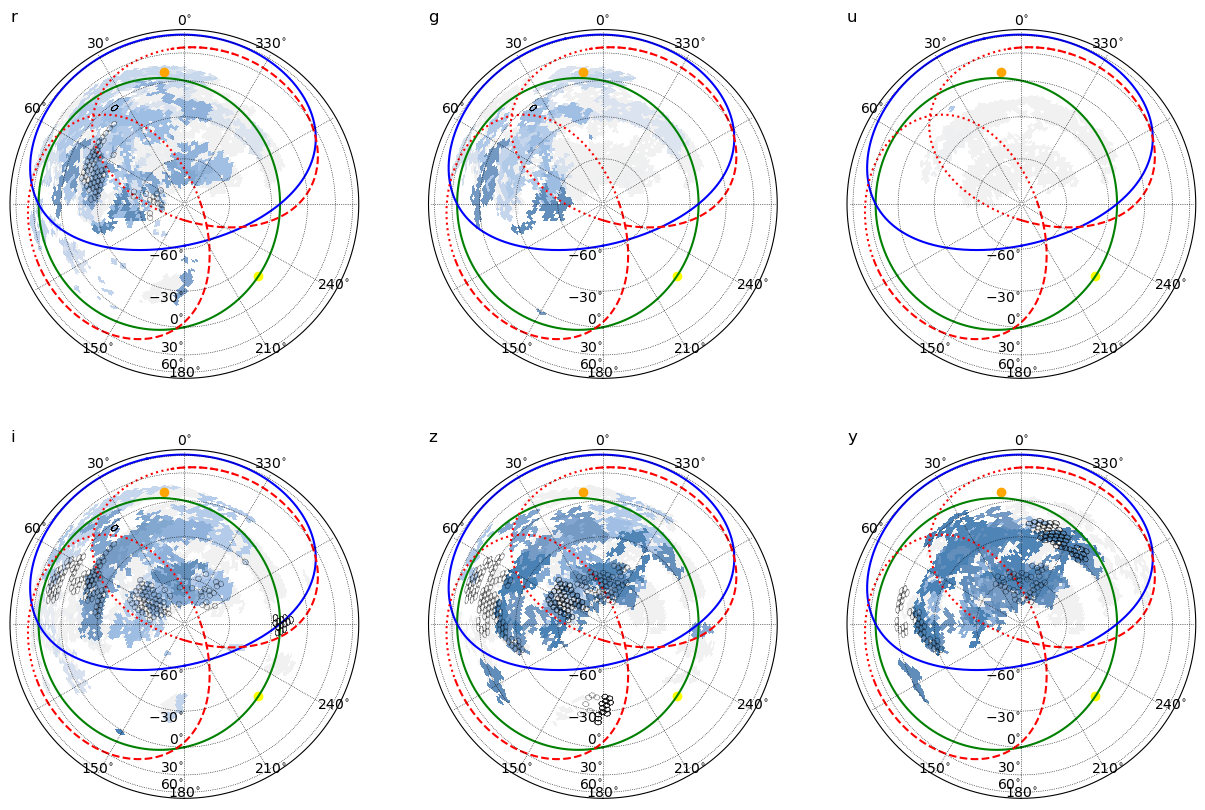

In [37]:
if use_matplotlib:
    cmap = colorcet.cm.blues_r
    fig = schedview.plot.survey_skyproj.create_hpix_visit_map_grid(visits, time_since_latest_hpix, model_observatory, night_events, vmin=0, vmax=10, cmap=cmap)
else:
    map_grid = schedview.plot.create_hpix_visit_map_grid(
        time_since_latest_hpix,
        visits,
        conditions,
        scale_limits=[10, 0],
    )
    bokeh.io.show(map_grid)

## DDF Cadence

In [38]:
time_window_duration = 120

In [39]:
# offset by 0.5 to get to the right rollover for day_obs, and to make the range inclusive
ddf_start_time = Time(day_obs_mjd - time_window_duration - 0.5, format='mjd')
ddf_end_time = Time(day_obs_mjd + 0.5, format='mjd')
ddf_visits = schedview.collect.opsim.read_ddf_visits(visit_db_fname, ddf_start_time, ddf_end_time)

In [40]:
nightly_ddf = schedview.compute.visits.accum_teff_by_night(ddf_visits)

In [41]:
cadence_plots = schedview.plot.create_cadence_plot(nightly_ddf, day_obs_mjd - time_window_duration, day_obs_mjd)
bokeh.io.show(cadence_plots)

## Table of exposures

In [42]:
displayed_columns = ['start_date', 'fieldRA', 'fieldDec', 'filter', 'visitExposureTime', 'numExposures', 'teff', 'skyBrightness', 'seeingFwhmEff', 'cloud', 'note']
displayed_visits_df = visits.loc[:, displayed_columns]
with pd.option_context('display.max_rows', 2000):
    display(displayed_visits_df)

start_date     fieldRA   fieldDec  \
observationId                                                              
574815        2027-11-11 00:11:29.469806848+00:00  273.872670 -26.811630   
574816        2027-11-11 00:11:50.241490688+00:00  270.391667 -27.213913   
574817        2027-11-11 00:12:11.040894976+00:00  268.038960 -24.908881   
574818        2027-11-11 00:12:31.809601536+00:00  264.623586 -25.149016   
574819        2027-11-11 00:12:52.128139520+00:00  265.785372 -22.539402   
574820        2027-11-11 00:13:12.443056384+00:00  266.885421 -19.922716   
574821        2027-11-11 00:13:33.260284160+00:00  269.124280 -22.285370   
574822        2027-11-11 00:13:53.583609856+00:00  270.157828 -19.662043   
574823        2027-11-11 00:14:13.900980992+00:00  271.147076 -17.041697   
574824        2027-11-11 00:14:34.211794176+00:00  272.099047 -14.425671   
574825        2027-11-11 00:14:55.153704192+00:00  273.454028 -19.293116   
574826        2027-11-11 00:15:15.488657408+00:00  272.476501 -21.929602   
574827        2027-11-11 00:15:35.828518912+00:00  271.457850 -24.570855   
574828        2027-11-11 00:15:56.635245568+00:00  273.872670 -26.811630   
574829        2027-11-11 00:16:17.404314368+00:00  270.391667 -27.213913   
574830        2027-11-11 00:16:38.205931520+00:00  268.038960 -24.908881   
574831        2027-11-11 00:16:58.972183808+00:00  264.623586 -25.149016   
574832        2027-11-11 00:17:19.286336256+00:00  265.785372 -22.539402   
574833        2027-11-11 00:17:39.596787456+00:00  266.885421 -19.922716   
574834        2027-11-11 00:18:00.415503616+00:00  269.124280 -22.285370   
574835           2027-11-11 00:18:20.733760+00:00  270.157828 -19.662043   
574836        2027-11-11 00:18:41.046142208+00:00  271.147076 -17.041697   
574837        2027-11-11 00:19:01.352047104+00:00  272.099047 -14.425671   
574838        2027-11-11 00:19:22.296049408+00:00  273.454028 -19.293116   
574839        2027-11-11 00:19:42.625289216+00:00  272.476501 -21.929602   
574840        2027-11-11 00:20:02.959478016+00:00  271.457850 -24.570855   
574841        2027-11-11 00:20:23.768135936+00:00  273.872670 -26.811630   
574842        2027-11-11 00:20:44.534548992+00:00  270.391667 -27.213913   
574843        2027-11-11 00:21:05.338379264+00:00  268.038960 -24.908881   
574844        2027-11-11 00:21:26.102096640+00:00  264.623586 -25.149016   
574845        2027-11-11 00:21:46.412024832+00:00  265.785372 -22.539402   
574846        2027-11-11 00:22:06.718251520+00:00  266.885421 -19.922716   
574847        2027-11-11 00:22:27.538496512+00:00  269.124280 -22.285370   
574848        2027-11-11 00:22:47.851924992+00:00  270.157828 -19.662043   
574849        2027-11-11 00:23:08.159519488+00:00  271.147076 -17.041697   
574850        2027-11-11 00:23:28.460757248+00:00  272.099047 -14.425671   
574851        2027-11-11 00:23:49.407012352+00:00  273.454028 -19.293116   
574852        2027-11-11 00:24:09.730820864+00:00  272.476501 -21.929602   
574853        2027-11-11 00:24:30.059497728+00:00  271.457850 -24.570855   
574854        2027-11-11 00:24:50.870167296+00:00  273.872670 -26.811630   
574855        2027-11-11 00:25:11.633844736+00:00  270.391667 -27.213913   
574856        2027-11-11 00:25:32.439887616+00:00  268.038960 -24.908881   
574857        2027-11-11 00:26:49.789980928+00:00  315.479193 -30.123393   
574858        2027-11-11 00:28:00.498307840+00:00  322.734164 -54.841764   
574859        2027-11-11 00:28:40.575499520+00:00  317.648566 -53.803451   
574860        2027-11-11 00:29:27.181724416+00:00  336.575795 -53.700282   
574861        2027-11-11 00:30:08.554825216+00:00  342.600117 -58.490763   
574862        2027-11-11 00:30:48.593795328+00:00  347.727629 -65.774131   
574863        2027-11-11 00:31:38.637136896+00:00  314.373086 -69.641141   
574864        2027-11-11 00:32:17.979188480+00:00  307.425423 -71.399273   
574865        2027-11-11 00:33:19.203398912+00:00   15.651040 -76.536254   
574866     